In [32]:
import datetime
import pickle
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import polars as pl
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error

from src.processing import preprocessing

warnings.filterwarnings("ignore", category=FutureWarning, message="The behavior of DatetimeProperties.to_pydatetime is deprecated")

DATA_DIR = Path("../data")

In [3]:
df = pl.read_csv(DATA_DIR / "PJME_hourly.csv")
split_date = datetime.datetime(2015, 1, 1)

df = preprocessing(df)
df_train, df_test = df.filter(pl.col("ds") <= split_date), df.filter(pl.col("ds") > split_date)
df_train, df_test = df_train.to_pandas(), df_test.to_pandas()

### 2ndモデル
- weeklyの傾向からオフィスが休みかどうかが影響を与えていそうなので、祝日も同様の傾向が見られる可能性がある。
- 祝日効果を考慮し、アメリカの祝日をmodelに情報として加える
- 結果
  - なんとスコアが悪化した
  - lightgbmはこの特徴量でスコア向上
  - 祝日によって結果が異なる可能性がある。

In [30]:
model = Prophet()
model.add_country_holidays(country_name="US")
model.fit(df_train)

preds = model.predict(df_test)
mae = mean_absolute_error(
    df_test["y"],
    pl.DataFrame(preds).filter(pl.col('ds') > split_date)["yhat"],
)
print(f"MAE: {mae}")  # baseline MAE: 5182.584236652587

00:52:37 - cmdstanpy - INFO - Chain [1] start processing
00:53:25 - cmdstanpy - INFO - Chain [1] done processing


MAE: 5198.819899787533


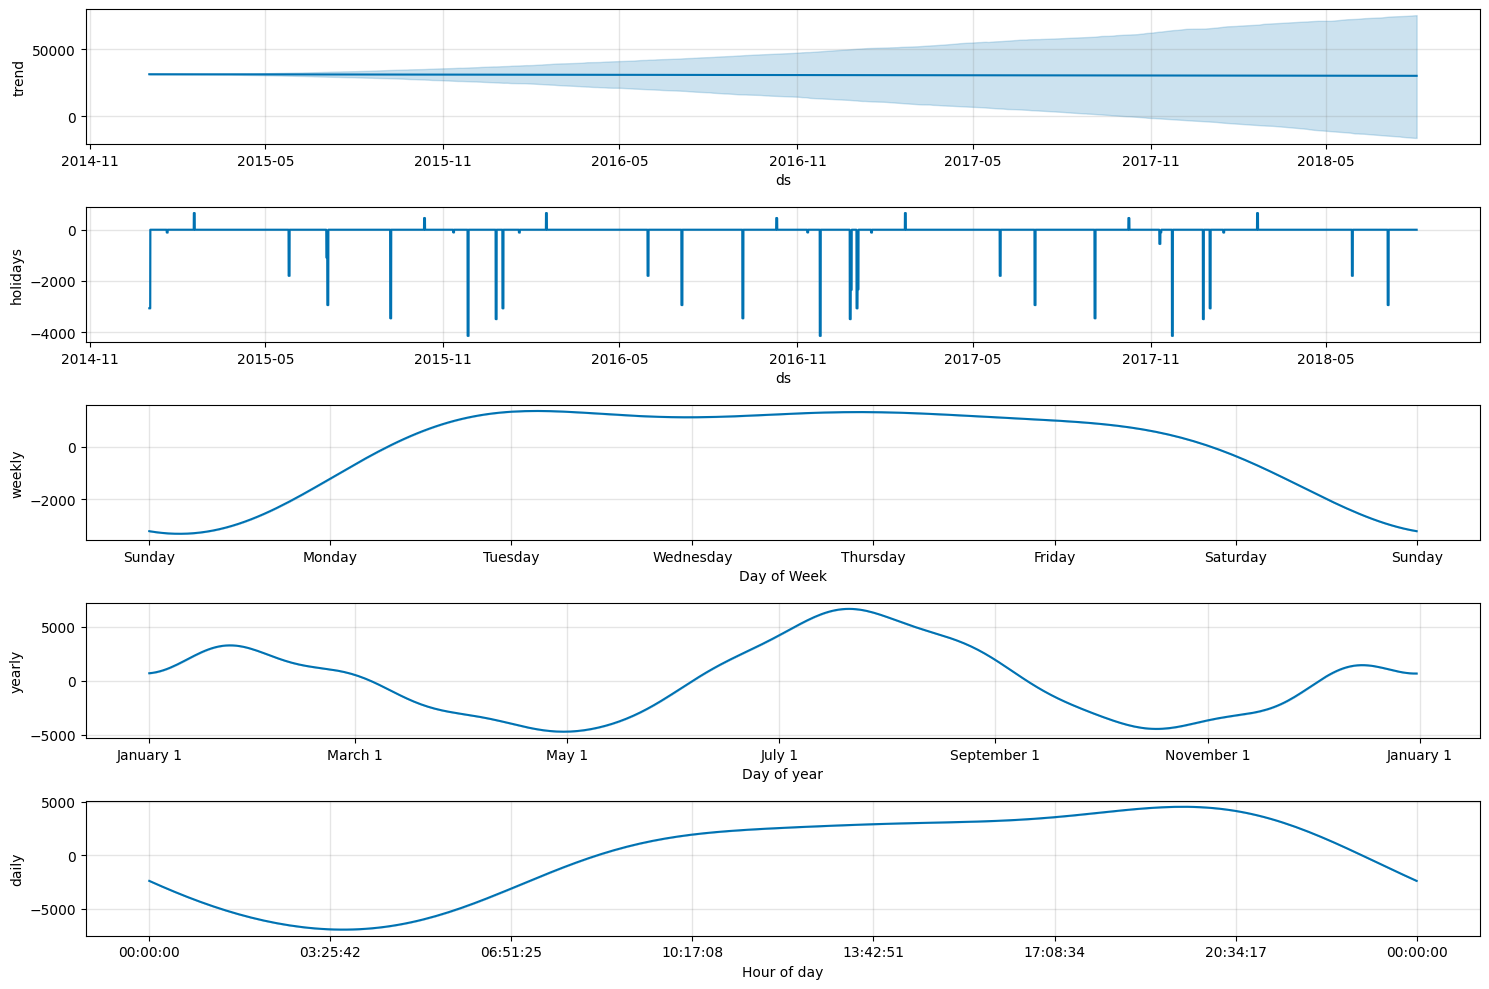

In [10]:
model.plot_components(preds, figsize=(15, 10));

祝日である2015/7/4を例に、baselineと比較してみる。  
この区間では、祝日効果を入れた2ndモデルの方がより良い予測ができているように見える。  
RMSEを比較しても、かなり良くなっている。では他の祝日ではどうか？

Baseline MAE: 5706.700734180132, 2nd model MAE: 2919.6285683082247


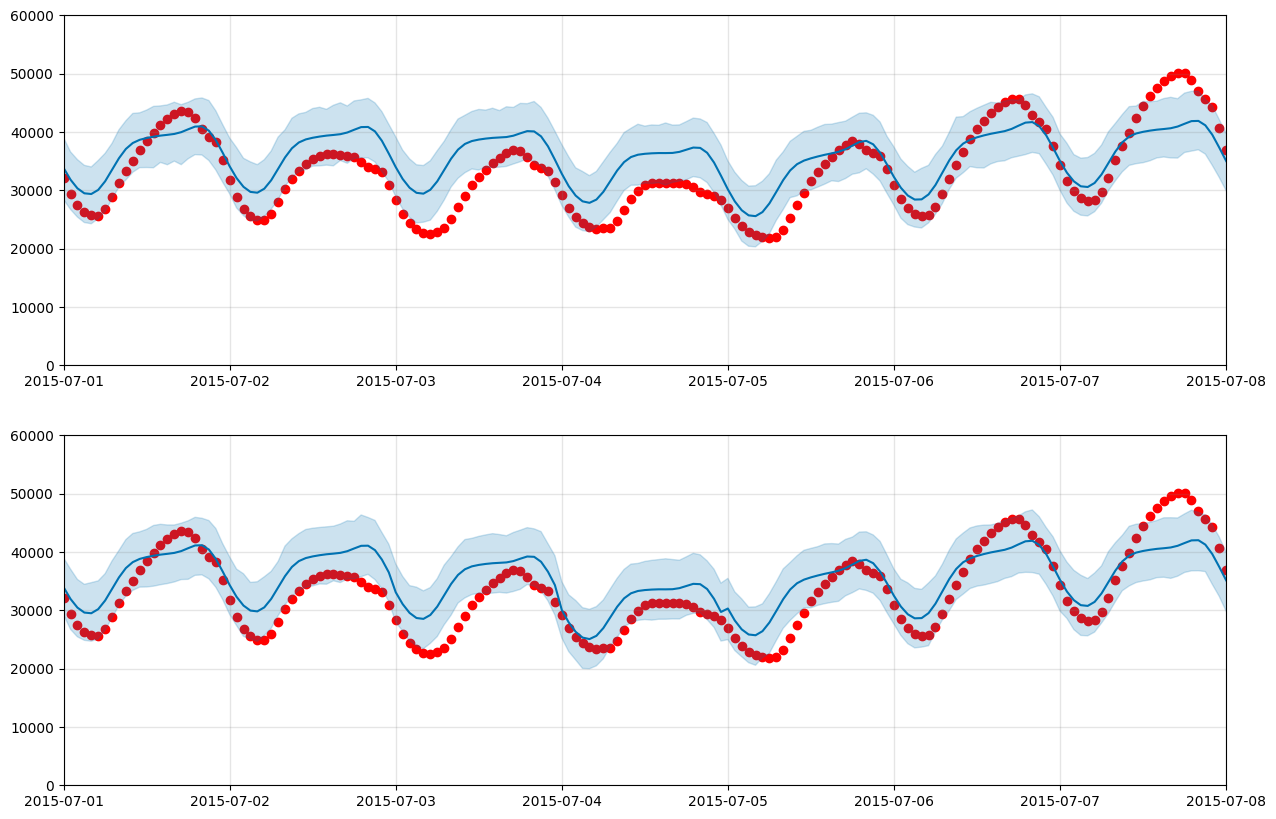

In [48]:
def custom_plot(df: pd.DataFrame, model, start: datetime.datetime, end: datetime.datetime, ax: plt.Axes,):
    ax.scatter(df["ds"], df["y"], color="r")
    preds = model.predict(df)
    fig = model.plot(preds, ax=ax)
    ax.set_xbound(lower=start, upper=end)
    ax.set_ylim(0, 60000);
    ax.set_xlabel("")
    ax.set_ylabel("")

baseline_model = pickle.load(open("../data/output/baseline_model.pkl", "rb"))

_, axes = plt.subplots(2, 1, figsize=(15, 10))
# baseline
custom_plot(df_test, baseline_model, datetime.datetime(2015, 7, 1), datetime.datetime(2015, 7, 8), axes[0])
# 2nd model
custom_plot(df_test, model, datetime.datetime(2015, 7, 1), datetime.datetime(2015, 7, 8), axes[1])

# MAE
baseline_preds = baseline_model.predict(df_test)
second_model_preds = model.predict(df_test)
baseline_mae = mean_absolute_error(
    df_test.query("ds >= '2015-07-04' and ds < '2015-07-05'")["y"],
    baseline_preds.query("ds >= '2015-07-04' and ds < '2015-07-05'")["yhat"],
)
second_model_mae = mean_absolute_error(
    df_test.query("ds >= '2015-07-04' and ds < '2015-07-05'")["y"],
    second_model_preds.query("ds >= '2015-07-04' and ds < '2015-07-05'")["yhat"],
)
print(f"Baseline MAE: {baseline_mae}, 2nd model MAE: {second_model_mae}")

全部の祝日に対して、baselineと2ndモデル（祝日効果）のMAEを比較してみる
- 結果
  - 精度向上している祝日もあれば、悪化している祝日もある
  - 一概に全部の祝日を情報としてInputするのではなく、個々に見ていく必要がありそう

In [68]:
def get_holidays(start: datetime.datetime, end: datetime.datetime) -> pd.core.indexes.datetimes.DatetimeIndex:
    cal = calendar()
    holidays = cal.holidays(start=start, end=end)
    return holidays

compared_df = None
for holiday in get_holidays(df_test["ds"].min(), df_test["ds"].max()):
    start, end = holiday, holiday + pd.Timedelta(days=1)
    y_true = df_test.query("ds >= @start and ds < @end")["y"]

    baseline_mae = mean_absolute_error(
        y_true,
        baseline_preds.query("ds >= @start and ds < @end")["yhat"],
    )
    second_model_mae = mean_absolute_error(
        y_true,
        second_model_preds.query("ds >= @start and ds < @end")["yhat"],
    )
    tmp_df = pl.DataFrame({
        "holiday": holiday,
        "baseline_mae": baseline_mae,
        "second_model_mae": second_model_mae,
        "diff": second_model_mae - baseline_mae,
    })
    if compared_df is None:
        compared_df = tmp_df
    else:
        compared_df = compared_df.vstack(tmp_df)

In [83]:
print(f"祝日モデルで精度改善した祝日数: {compared_df.filter(pl.col('diff') < 0).shape[0]}")
print(f"祝日モデルで精度悪化した祝日数: {compared_df.filter(pl.col('diff') > 0).shape[0]}")
print(f"変化なし: {compared_df.filter(pl.col('diff') == 0).shape[0]}")

祝日モデルで精度改善した祝日数: 20
祝日モデルで精度悪化した祝日数: 14
変化なし: 0
diff合計: -10486.425798281594
